In [ ]:
!pip install pydub

In [ ]:
import json
import os
import pprint

import librosa
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from pydub import AudioSegment  
import matplotlib.pyplot as plt
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Split by duration in cha files.

In [ ]:
def load_meta_info(meta_path):
  with open(meta_path) as meta_file:
    meta_data = json.load(meta_file)
  return meta_data

In [ ]:
def split_meta_info(meta_info_path, audio_raw_path, audio_split_path):
  """
  Split data according to json meta data 
  :param meta_info_path: path to a json file
  :param audio_raw_path: path to a dir with raw not splitted audio
  :param audio_split_path: path to a dir for new splitted audio
  """
  meta_info = load_meta_info(meta_info_path)
  clean_info = []


  for audio_name in meta_info:
    audio_path = os.path.join(audio_raw_path, audio_name[:-4] + '.mp3')
    wave = AudioSegment.from_mp3(audio_path)

    for record_info in meta_info[audio_name][1]:
      start, end = record_info['seconds'][0], record_info['seconds'][1]
      condition = meta_info[audio_name][0][0]['condition']
      fragment_path = os.path.join(audio_split_path, f'{audio_name[:-4]}_{condition}_{start}.wav')
      fragment_audio = wave[start:end]
      os.chdir(audio_split_path)
      fragment_audio.export(f'{audio_name[:-4]}_{condition}_{start}.wav', format='wav')

      record_info['fragment_name'] = fragment_path
      record_info['condition'] = condition

      clean_info.append(record_info)
  return clean_info

It returns the list of all records and saves splitted by cha file data audio fragments. Example of usage:

In [ ]:
#info to split data, it should  be changed according to a new dataset

# meta_info_path = r''
# audio_raw_path = r''
# audio_split_path = r''

# info = split_meta_info(meta_info_path, audio_raw_path, audio_split_path)

In [ ]:
#pattern to save split info
# os.chdir('')
# with open('hopkins_dementia.json', 'w') as json_file:
#   json.dump(info, json_file)

Get all info from not dementia and dementia files. 

In [ ]:
def add_data_dementia(dementia_paths):
  info = []
  for dementia_path in dementia_paths:
    with open(dementia_path) as json_file:
      local_info = json.load(json_file)
      info.extend(local_info)
  return info

dementia_paths = ['']

control_paths = ['']

# info_dementia = add_data_dementia(dementia_paths)
# info_not_dementia = add_data_dementia(control_paths)

### Saving specs, not audio. 

In [ ]:
def get_spectrograms(filepath, output_dir):
    
    # Open the file with librosa (limited to the first 15 seconds)
    sig, rate = librosa.load(filepath, sr=SAMPLE_RATE, offset=None, duration=15)
    
    # Split signal into five second chunks
    sig_splits = [sig]

    saved_samples = []
    for chunk in sig_splits:
        
        hop_length = int(SIGNAL_LENGTH * SAMPLE_RATE / (SPEC_SHAPE[1] - 1))
        mel_spec = librosa.feature.melspectrogram(y=chunk, 
                                                  sr=SAMPLE_RATE, 
                                                  n_fft=1024, 
                                                  hop_length=hop_length, 
                                                  n_mels=SPEC_SHAPE[0], 
                                                  fmin=FMIN, 
                                                  fmax=FMAX)
    
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max) 
        
        mel_spec -= mel_spec.min()
        mel_spec /= mel_spec.max()
    
    # Save as image file
        save_dir = output_dir
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        save_path = os.path.join(save_dir, filepath.rsplit(os.sep, 1)[-1].rsplit('.', 1)[0] + '.png')
        im = Image.fromarray(mel_spec * 255.0).convert("L")
        im.save(save_path)
        
        saved_samples.append(save_path)
        
    return saved_samples

Example of usage:

In [ ]:
# audio_fragments_path = r''
# specs_save_path = r''

# saved_samples = []

# for audio_file in os.listdir(audio_fragments_path):
#   audio_file_path = os.path.join(audio_fragments_path, audio_file)
#   saved_spec = get_spectrograms(audio_file_path, specs_save_path)
#   saved_samples.append(saved_spec)

# Split by sr

We first split everything by 5 seconds.

1.   first split everything by 5 seconds
2.   get melspectrograms
3.   save specs in torch tensor

In [ ]:
def split_audios_by_frames(audio_path):
  """
  Split audio file according by seconds - 5 seconds 
  :param audio_path - the path of one audio fragments, supposed to be long one. 
  """
  wav, sr = torchaudio.load(audio_path)
  resample = torchaudio.transforms.Resample(sr, 16000)
  sr = 16000
  wav = resample(wav)
  wav = torch.mean(wav, 0)
  split_size_seconds = 10
  split_size_samples = int(sr * split_size_seconds)
  chunks = list(torch.split(wav, split_size_samples, dim=-1))

  #do padding
  for idx, chunk in enumerate(chunks):
    if chunk.shape[0] != chunks[0].shape[0]:
      shortage = split_size_seconds * sr - chunk.shape[0]
      chunks[idx] = torch.nn.functional.pad(chunk, (0, shortage))
  return chunks

In [ ]:
def get_spec(audio_tensor, sr=44100): 
    params = {
        'sample_rate': sr, 'hop_length': 512,
        'n_fft': 1024, 
    }
    s = torchaudio.transforms.MelSpectrogram(**params)(audio_tensor)
    s = torchaudio.transforms.AmplitudeToDB()(s)
    s = (s - s.mean()) / s.std()
    return s

In [ ]:
def show_spec(s):
    print(s.shape, s.mean().item(), s.std().item())
    fig, ax = plt.subplots(figsize=(5,2))
    params = {'origin':'lower','cmap':'magma'}
    ax.imshow(s, **params)
    plt.show()

In [ ]:
#for all folders
def get_all_specs(folders):
  specs = []

  for folder in folders:
    paths = [folder + '/' + path for path in os.listdir(folder)]
    for path in paths:
      chunks = split_audios_by_frames(path)
      local_specs = [get_spec(chunk).unsqueeze(0) for chunk in chunks]
      specs += local_specs
  return torch.cat(specs)

In [ ]:
specs = get_all_specs(['/content/drive/MyDrive/course_work_milana/pitt/dementia'])

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


In [ ]:
specs.shape

torch.Size([2497, 128, 313])

In [ ]:
torch.save(specs, '/content/drive/MyDrive/course_work_milana/TENSORS_SAVED/Dementia/dementia_pitt' + '.pt')

### example with displaying

In [ ]:
from IPython.display import Audio, display
import librosa.display
from tqdm.notebook import tqdm

In [ ]:
chunks = split_audios_by_frames('')

In [ ]:
spec = get_spec(chunks[6])
spec.shape

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


torch.Size([128, 313])

In [ ]:
Audio(chunks[25], rate=16000)

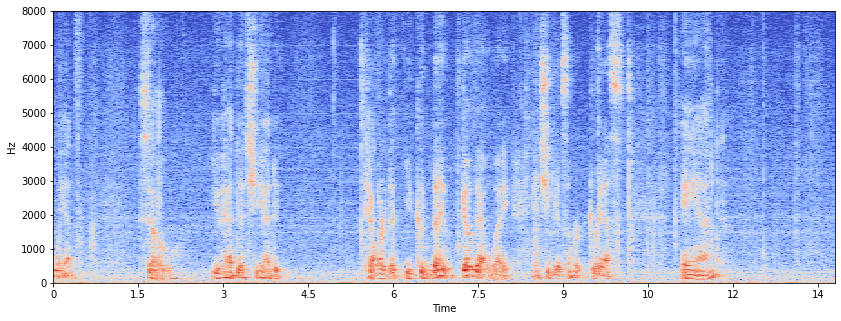

In [ ]:
X = librosa.stft(chunks[10].numpy())
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=16000, x_axis='time', y_axis='hz')

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

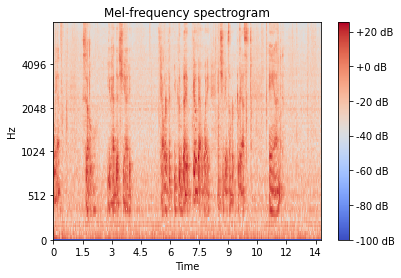

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(spec.numpy(), x_axis='time',
                         y_axis='mel', sr=16000,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
torch.save(control, control_save_path + '.pt')

# Data loaders

## Dataset for multi: text and audio 

In [ ]:
class DementiaDatasetMulti(Dataset):
  def __init__(self, info, tokenizer):
    self.info = info
    self.all_conditions = {'Dementia': 1, "NotDementia": 0, 'PPA-NOS':1}
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.info)

  def __getitem__(self, idx):
    text = self.info[idx]['text']
    audio_path = self.info[idx]['fragment_name']
    target = self.all_conditions[self.info[idx]['condition']]

    spec = self.preprocess_audio(audio_path)
    text = self.preprocess_text(text)
    return {"text": text, "audio": audio, "target": target}

  def load_sample(self, file_path):
    image = Image.open(file_path)
    image.load()
    return image

  @staticmethod
  def normalize(audio_spect, eps=1e-6):
    mean = audio_spect.mean()
    std = audio_spect.std()
    spec_norm = (audio_spect - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    return spec_scaled

  def preprocess_text(self, text, max_length=25):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(r'\s+', ' ', text)

    ids = self.tokenizer.convert_tokens_to_ids(self.tokenizer.tokenize(text))
    tokens = self.tokenizer.prepare_for_model(ids, max_length=25, truncation=True, pad_to_max_length=True)['input_ids']
    return tokens

In [ ]:
def collate_batch(batch):
   
  labels, texts, audios = [], [], []
  for batch_info in batch:
    labels.append(batch_info['target'])
    texts.append(batch_info['text'])
    audios.append(batch_info['audio'])

  labels = torch.tensor(labels, dtype=torch.int64)
  texts = torch.tensor(texts)
  audios = torch.tensor(audios)

  return {"text": texts, "audio": audios, "labels": labels}

## Dataset for audio as saved audio. Version used now. 

In [ ]:
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

In [ ]:
class DementiaDatasetSpecs(Dataset):
  def __init__(self, info):
    self.info = info
    self.all_conditions = {'dementia': 1, "control": 0}

  def __len__(self):
    return len(self.info)

  def __getitem__(self, idx):
    spec = self.info[idx]['spec']
    target = self.all_conditions[self.info[idx]['condition']]

    return {"spec": spec, "target": target}

In [ ]:
def collate_batch(batch):
   
  labels, specs = [], []
  for batch_info in batch:
    labels.append(batch_info['target'])
    specs.append(batch_info['spec'])

  labels = torch.tensor(labels, dtype=torch.int64)
  
  specs = torch.stack(specs, 0)

  return {"specs": specs, "labels": labels}

## Dataset for audio as images. 

In [ ]:
class DementiaDatasetSpecs(Dataset):
  def __init__(self, info, rescale_size=224):
    self.info = info
    self.all_conditions = {'Dementia': 1, "NotDementia": 0, 'PPA-NOS':1}
    self.transform = transforms.ToTensor() #maybe change to compose

    self.rescale_size = rescale_size

  def __len__(self):
    return len(self.info)

  def __getitem__(self, idx):
    spec_path = self.info[idx]['path']
    target = self.all_conditions[self.info[idx]['condition']]

    spec = self._prepare_sample(self.load_sample(spec_path))
    return {"spec": spec, "target": target}

  def load_sample(self, file_path, dir_path=''):
    image = Image.open(dir_path + file_path)
    image.load()
    return image

  def _prepare_sample(self, spec):
    spec = spec.resize((self.rescale_size, self.rescale_size))
    spec = self.transform(np.array(spec))
    return spec

In [ ]:
def collate_batch(batch):
   
  labels, specs = [], []
  for batch_info in batch:
    labels.append(batch_info['target'])
    specs.append(batch_info['spec'])

  labels = torch.tensor(labels, dtype=torch.int64)
  specs = torch.stack(specs, 0)

  return {"specs": specs, "labels": labels}